In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn
import os
from datetime import datetime, timedelta
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input, TimeDistributed, LeakyReLU, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,TensorBoard

In [2]:
os.listdir('./data/')

['DJI_fe.csv',
 'DJI_STO_20period_sma10.csv',
 '.DS_Store',
 'N225.csv',
 'DJI_modified_features - DJI.csv',
 'preprocessed',
 'N225fillVOL.csv',
 'DJI_modified_sma.csv',
 'downjone5y.csv',
 'N225withoutNULL.csv',
 'stocknews',
 'dowjone1985_2019.csv',
 '.ipynb_checkpoints',
 'DJI_ema.csv',
 'DJI_denoise.csv',
 'test_djia.csv']

In [3]:
df_nikkei = pd.read_csv('./data/N225withoutNULL.csv')
df_djia = pd.read_csv('./data/DJI_modified_sma.csv')

In [4]:
df_nikkei.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0
3,1985-02-01,11946.959961,11946.959961,11946.959961,11946.959961,11946.959961,0
4,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0


In [5]:
df_djia['Date'][0]

'1985-01-29'

# Preprocess

In [6]:
# postpone 1 day and concatenate both table

# decrement datetime of djia first
df_djia_dc = df_djia.copy()
# df_djia_dc['Date'] = df_djia['Date'] + timedelta(days=-1)
for i in tqdm(range(len(df_djia))):
    df_djia_dc['Date'][i] = str((datetime.strptime(df_djia.iloc[i]['Date'], '%Y-%m-%d') + timedelta(days=-1)).date())

# df_djia_dc.head()
df = pd.merge(df_nikkei, df_djia_dc, on='Date', how='inner')
df = df.rename({'Open_x': 'Open(Nikkei)', 'High_x': 'High(Nikkei)', 'Low_x': 'Low(Nikkei)', 'Close_x': 'Close(Nikkei)',
                'Open_y': 'Open(DJIA)', 'High_y': 'High(DJIA)', 'Low_y': 'Low(DJIA)', 'Close_y': 'Close(DJIA)'
               }, axis=1)


  0%|          | 0/8762 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 8762/8762 [00:05<00:00, 1485.17it/s]


In [7]:
df.head()

,Date,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Adj Close_x,Volume_x,Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA),Adj Close_y,Volume_y,sma5,sma10,sma25,sma75,sma125,sma200
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971
3,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0,1294.060059,1301.130005,1278.599976,1285.229980,1285.229980,13800000,1285.535986,1285.229980,1285.229980,1285.229980,1285.229980,1285.229980
4,1985-02-05,11823.429688,11823.429688,11823.429688,11823.429688,11823.429688,0,1284.890015,1294.500000,1275.069946,1280.589966,1280.589966,14610000,1284.077979,1280.589966,1280.589966,1280.589966,1280.589966,1280.589966


In [8]:
# df_djia_dc.iloc[0]['Date']

In [9]:
event_col = ['Open(Nikkei)', 'High(Nikkei)', 'Low(Nikkei)', 'Close(Nikkei)',
            'Open(DJIA)', 'High(DJIA)', 'Low(DJIA)', 'Close(DJIA)'
            ]
total_col = df.columns
for col in total_col:
    if col not in event_col:
        df = df.drop(col, axis=1)

In [10]:
df.tail()

,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA)
6906,22619.769531,22648.810547,22457.890625,22625.380859,26893.92969,26931.77930,26714.33984,26805.52930
6907,22725.439453,22780.990234,22704.330078,22750.599609,26789.60938,27015.36914,26765.67969,26958.06055
6908,22854.439453,22896.220703,22830.570313,22867.269531,27061.07031,27165.93945,27039.75977,27071.46094
6909,22950.789063,23008.429688,22935.349609,22974.130859,27110.71094,27204.35938,26999.64063,27186.68945
6910,22953.169922,22961.230469,22827.929688,22843.119141,27188.36914,27188.36914,26918.28906,27046.23047


In [11]:
def normalize_data(df, event_col):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    for col in event_col:
        if col != 'Date':
            df[col] = min_max_scaler.fit_transform(df[col].to_numpy().reshape(-1, 1))
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]
    

In [12]:
# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_norm = normalize_data(df, event_col)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (5513, 19, 8)
y_train.shape =  (5513, 8)
x_val.shape =  (689, 19, 8)
y_val.shape =  (689, 8)
x_test.shape =  (689, 19, 8)
y_test.shape =  (689, 8)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


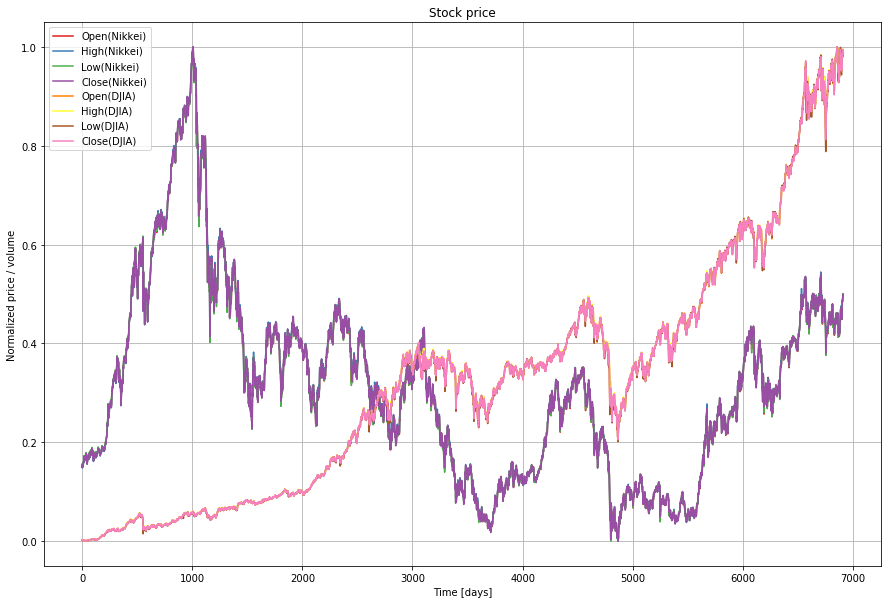

In [13]:
# plot graph before train

# !set color in graph
# color_palette = ...
plt.figure(figsize=(15, 10))
plt.grid()
color_palette = plt.get_cmap('Set1')
for i, col in enumerate(event_col):
    plt.plot(df_norm[col], color=color_palette(i), label=col)
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend()
plt.show()

In [16]:
# hyperparameter 
batch_size = 1024
epochs = 300

# set up callback_list
weight_path_model = "saved_model/djia_nk_test.h5"
tensorboard_path = 'Graph/djia_support_nikkei_test'
callbacks_list_model = [
    TensorBoard(log_dir=tensorboard_path),
    ModelCheckpoint(
            weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, min_lr=1e-9)
]

In [25]:
K.clear_session()

def get_bi_gru():
    
    input1 = Input(shape=(19,8,))
    x = GRU(256, return_sequences=True)(input1)
    x = TimeDistributed(LeakyReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = GRU(128, dropout=0.5)(x)
    x =(LeakyReLU())(x)
    x = (BatchNormalization())(x)
    out = Dense(8)(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(lr=1e-4, decay=1e-4),
                loss='mse',
                metrics=['mse'])   
    
    return model

model = get_bi_gru()
model.summary()
    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 8)]           0         
_________________________________________________________________
gru (GRU)                    (None, 19, 256)           204288    
_________________________________________________________________
time_distributed (TimeDistri (None, 19, 256)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 256)           1024      
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               148224    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512   

# Experiment and Result

In [26]:
history = model.fit(x_train, y_train, epochs=epochs , callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) 

Train on 5513 samples, validate on 689 samples
Epoch 1/300
5120/5513 [==========================>...] - ETA: 1s - loss: 1.3406 - mse: 1.3406
Epoch 00001: val_loss did not improve from 0.17996
5513/5513 [==============================] - 15s 3ms/sample - loss: 1.3162 - mse: 1.3162 - val_loss: 0.2082 - val_mse: 0.2082
Epoch 2/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.8645 - mse: 0.8645
Epoch 00002: val_loss did not improve from 0.17996
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.8605 - mse: 0.8605 - val_loss: 0.2036 - val_mse: 0.2036
Epoch 3/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.7257 - mse: 0.7257
Epoch 00003: val_loss did not improve from 0.17996
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.7196 - mse: 0.7196 - val_loss: 0.2016 - val_mse: 0.2016
Epoch 4/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.5933 - mse: 0.5933
Epoch 00004: val_loss did not improve from 0.179

Epoch 28/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0878 - mse: 0.0878
Epoch 00028: val_loss improved from 0.09269 to 0.08992, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0874 - mse: 0.0874 - val_loss: 0.0899 - val_mse: 0.0899
Epoch 29/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0833 - mse: 0.0833
Epoch 00029: val_loss improved from 0.08992 to 0.08750, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0831 - mse: 0.0831 - val_loss: 0.0875 - val_mse: 0.0875
Epoch 30/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0812 - mse: 0.0812
Epoch 00030: val_loss improved from 0.08750 to 0.08467, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0811 - mse: 0.0811 - val_loss: 0.0847 - val_mse: 0.0847
Epoch 31/300
5120/5513 [================

Epoch 54/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0347 - mse: 0.0347
Epoch 00054: val_loss improved from 0.05582 to 0.05535, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0553 - val_mse: 0.0553
Epoch 55/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0338 - mse: 0.0338
Epoch 00055: val_loss improved from 0.05535 to 0.05467, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0547 - val_mse: 0.0547
Epoch 56/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0327 - mse: 0.0327
Epoch 00056: val_loss improved from 0.05467 to 0.05312, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 57/300
5120/5513 [================

5120/5513 [==========================>...] - ETA: 1s - loss: 0.0160 - mse: 0.0160
Epoch 00080: val_loss improved from 0.03618 to 0.03554, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 81/300
5120/5513 [==========================>...] - ETA: 1s - loss: 0.0155 - mse: 0.0155
Epoch 00081: val_loss improved from 0.03554 to 0.03535, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 16s 3ms/sample - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 82/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0149 - mse: 0.0149
Epoch 00082: val_loss improved from 0.03535 to 0.03436, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 11s 2ms/sample - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 83/300
5120/5513 [==========================

Epoch 106/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0085 - mse: 0.0085
Epoch 00106: val_loss improved from 0.01910 to 0.01854, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 107/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0082 - mse: 0.0082
Epoch 00107: val_loss improved from 0.01854 to 0.01776, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 11s 2ms/sample - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 108/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0079 - mse: 0.0079
Epoch 00108: val_loss improved from 0.01776 to 0.01755, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 109/300
5120/5513 [===========

5120/5513 [==========================>...] - ETA: 0s - loss: 0.0054 - mse: 0.0054
Epoch 00132: val_loss improved from 0.01176 to 0.01156, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 133/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0054 - mse: 0.0054
Epoch 00133: val_loss did not improve from 0.01156
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 134/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0052 - mse: 0.0052
Epoch 00134: val_loss improved from 0.01156 to 0.01123, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 135/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0052 - mse: 0.0052
Epoc

Epoch 159/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0041 - mse: 0.0041
Epoch 00159: val_loss improved from 0.00817 to 0.00815, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 160/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0039 - mse: 0.0039
Epoch 00160: val_loss improved from 0.00815 to 0.00801, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 6s 1ms/sample - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 161/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0040 - mse: 0.0040
Epoch 00161: val_loss improved from 0.00801 to 0.00780, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 162/300
5120/5513 [============

Epoch 186/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0033 - mse: 0.0033
Epoch 00186: val_loss did not improve from 0.00585
5513/5513 [==============================] - 6s 1ms/sample - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 187/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0033 - mse: 0.0033
Epoch 00187: val_loss did not improve from 0.00585
5513/5513 [==============================] - 6s 1ms/sample - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 188/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0032 - mse: 0.0032
Epoch 00188: val_loss improved from 0.00585 to 0.00579, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 189/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0032 - mse: 0.0032
Epoch 00189: val_loss improved from 0.0

Epoch 214/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0029 - mse: 0.0029
Epoch 00214: val_loss improved from 0.00482 to 0.00482, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 215/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0029 - mse: 0.0029
Epoch 00215: val_loss improved from 0.00482 to 0.00475, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 216/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0028 - mse: 0.0028
Epoch 00216: val_loss did not improve from 0.00475
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 217/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0028 - ms

Epoch 242/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0027 - mse: 0.0027
Epoch 00242: val_loss improved from 0.00435 to 0.00432, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 6s 1ms/sample - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 243/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0028 - mse: 0.0028
Epoch 00243: val_loss did not improve from 0.00432
5513/5513 [==============================] - 6s 1ms/sample - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 244/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0027 - mse: 0.0027
Epoch 00244: val_loss did not improve from 0.00432
5513/5513 [==============================] - 6s 1ms/sample - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 245/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0027 - mse: 0.0027
Epoch 00245: val_loss did not improve f

Epoch 270/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0026 - mse: 0.0026
Epoch 00270: val_loss improved from 0.00419 to 0.00419, saving model to saved_model/djia_nk_test.h5
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 271/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0026 - mse: 0.0026
Epoch 00271: val_loss did not improve from 0.00419
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 272/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0027 - mse: 0.0027
Epoch 00272: val_loss did not improve from 0.00419
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 273/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0027 - mse: 0.0027
Epoch 00273: val_loss did not improve 

5120/5513 [==========================>...] - ETA: 0s - loss: 0.0026 - mse: 0.0026
Epoch 00298: val_loss did not improve from 0.00412
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 299/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0026 - mse: 0.0026
Epoch 00299: val_loss did not improve from 0.00412
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 300/300
5120/5513 [==========================>...] - ETA: 0s - loss: 0.0026 - mse: 0.0026
Epoch 00300: val_loss did not improve from 0.00412
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0042 - val_mse: 0.0042


In [27]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])


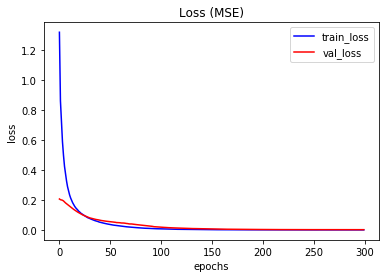

In [28]:
plt.title("Loss (MSE)")
plt.plot(history.history['loss'],color = 'blue',label="train_loss")
plt.plot(history.history['val_loss'],color = 'red',label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig('loss_support.png')

In [29]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [30]:
#fix!
def plot_compare(x, event_col):
#     Col = {'Open':0, 'High':1, 'Low':2, 'Close':3}
    Col = dict()
    count = 0
    for i, col in enumerate(event_col):
        Col[col] = i
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
            y_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
            y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price :' + x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices :' + x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')



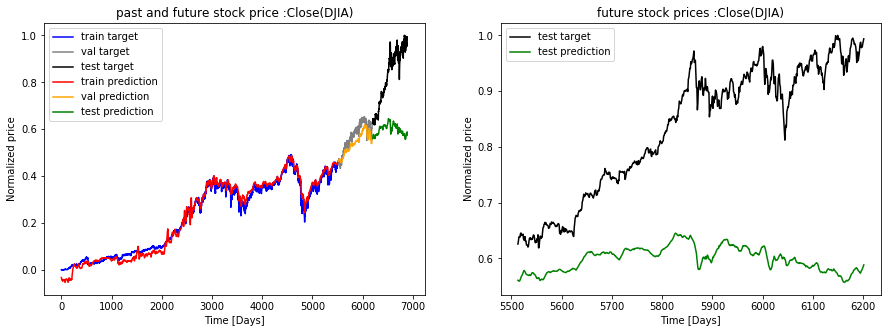

In [31]:
plot_compare('Close(DJIA)', event_col)